# Hail Comparison Grids

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy
import numpy as np

In [2]:
def radar_colormap():
    r"""Returns an NWS colormap.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    """ 
 
    nws_reflectivity_colors = ["#ffffff",  # 0
                               "#04e9e7",  # 5
                               "#019ff4",  # 10
                               "#0300f4",  # 15
                               "#02fd02",  # 20
                               "#01c501",  # 25
                               "#008e00",  # 30
                               "#fdf802",  # 35
                               "#e5bc00",  # 40
                               "#fd9500",  # 45
                               "#fd0000",  # 50
                               "#d40000",  # 55
                               "#bc0000",  # 60
                               "#f800fd",  # 65
                               "#9854c6",  # 70
                               "#4B0082",  # 75
                               "#000000"]
                                
    cmap = ListedColormap(nws_reflectivity_colors)
    
    return cmap

cmap = radar_colormap()

## 6-Hour MESH Hail Grids (Observations)
Data for this can be found in this repository: https://noaa-mrms-pds.s3.amazonaws.com/index.html#CONUS/MESH_Max_360min_00.50/

In [3]:
ds_mesh = xr.open_dataset(f'/home/scratch/jcorner1/NWP_Project/Other_Data/MESH/MRMS_MESH_Max_360min_00.50_20210429-030000.grib2')#, engine = 'netcdf4')
ds_mesh

<xarray.Dataset>
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] ...
    step            timedelta64[ns] ...
    heightAboveSea  float64 ...
  * latitude        (latitude) float64 54.99 54.98 54.98 ... 20.03 20.02 20.01
  * longitude       (longitude) float64 230.0 230.0 230.0 ... 300.0 300.0 300.0
    valid_time      datetime64[ns] ...
Data variables:
    unknown         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  161
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             161
    history:                 2023-12-04T19:51 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
ds_sel_mesh = ds_mesh.sel(latitude=slice(40,22), longitude=slice(360-107, 360-84))

mesh_lat = ds_sel_mesh.latitude.values
mesh_lon = ds_sel_mesh.longitude.values
mesh_val = ds_sel_mesh.unknown.values

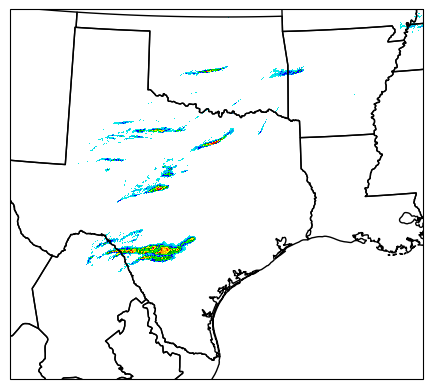

In [5]:
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(mesh_lon, mesh_lat, mesh_val, transform=cartopy.crs.PlateCarree(), cmap=cmap, vmin = 0, vmax=100)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.set_extent([-104.5,-90,25,37])

In [28]:
np.max(ds_sel_mesh.unknown.values)

95.5

## WRF Max Hail Diameter Grids

In [7]:
#load in the WRF geog file
geog = xr.open_dataset('/home/scratch/jcorner1/NWP_Project/geo_em.d01.nc')
new_geog = geog.drop({'XLAT_U', 'XLAT_V', 'XLONG_U', 'XLONG_V'})

### NSSL 1-Moment 7-Class Microphysics Scheme

In [8]:
#open the AFWA files together
ds = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/data1/AFWA*', concat_dim="Time", combine="nested")

#merge the file with the geom file
ds = xr.merge([ds, new_geog.squeeze()], compat='override')
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#assign the lat/lons
ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds_nsslsm = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds_nsslsm

<xarray.Dataset>
Dimensions:         (Time: 37, south_north: 432, west_east: 515,
                     south_north_stag: 433, west_east_stag: 516, land_cat: 20,
                     soil_cat: 16, month: 12, dust_erosion_dimension: 3)
Coordinates:
    lat             (south_north, west_east) float32 ...
    lon             (south_north, west_east) float32 ...
    x               (west_east) int64 0 1 2 3 4 5 6 ... 509 510 511 512 513 514
    y               (south_north) int64 0 1 2 3 4 5 ... 426 427 428 429 430 431
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month,
                                dust_erosion_dimension
Data variables: (12/80)
    Times           (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    WSPD10MAX       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_UP_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_DN_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    REFD_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    UP_HELI_MAX     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    ...              ...
    OL4             (south_north, west_east) float32 ...
    VAR_SSO         (south_north, west_east) float32 ...
    LAKE_DEPTH      (south_north, west_east) float32 ...
    EROD            (dust_erosion_dimension, south_north, west_east) float32 ...
    CLAYFRAC        (south_north, west_east) float32 ...
    SANDFRAC        (south_north, west_east) float32 ...
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.3.3 MODEL
    START_DATE:                      2021-04-28_18:00:00
    WEST-EAST_GRID_DIMENSION:        516
    SOUTH-NORTH_GRID_DIMENSION:      433
    BOTTOM-TOP_GRID_DIMENSION:       50
    DX:                              3750.0
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [9]:
nsslsm_lat = ds_nsslsm.lat.values
nsslsm_lon = ds_nsslsm.lon.values
nsslsm_val = ds_nsslsm.HAIL_MAX2D.max(dim='Time').values *1000

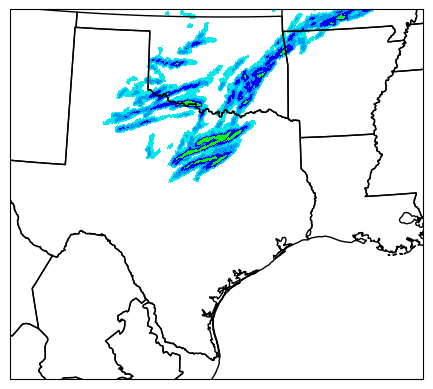

In [10]:
#plot the hail data
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(nsslsm_lon, nsslsm_lat, nsslsm_val, transform=cartopy.crs.PlateCarree(), cmap=cmap, vmin = 0, vmax=100)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.set_extent([-104.5,-90,25,37])

In [24]:
np.max(ds_nsslsm.HAIL_MAX2D.max(dim='Time').values) *39.3701

1.1285163660215214

### Thompson (Hail) Microphysics Scheme

In [12]:
#open the AFWA files together
ds = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/data4/AFWA*', concat_dim="Time", combine="nested")

#merge the file with the geom file
ds = xr.merge([ds, new_geog.squeeze()], compat='override')
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#assign the lat/lons
ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds_th = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds_th

<xarray.Dataset>
Dimensions:         (Time: 37, south_north: 432, west_east: 515,
                     south_north_stag: 433, west_east_stag: 516, land_cat: 20,
                     soil_cat: 16, month: 12, dust_erosion_dimension: 3)
Coordinates:
    lat             (south_north, west_east) float32 ...
    lon             (south_north, west_east) float32 ...
    x               (west_east) int64 0 1 2 3 4 5 6 ... 509 510 511 512 513 514
    y               (south_north) int64 0 1 2 3 4 5 ... 426 427 428 429 430 431
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month,
                                dust_erosion_dimension
Data variables: (12/80)
    Times           (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    WSPD10MAX       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_UP_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_DN_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    REFD_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    UP_HELI_MAX     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    ...              ...
    OL4             (south_north, west_east) float32 ...
    VAR_SSO         (south_north, west_east) float32 ...
    LAKE_DEPTH      (south_north, west_east) float32 ...
    EROD            (dust_erosion_dimension, south_north, west_east) float32 ...
    CLAYFRAC        (south_north, west_east) float32 ...
    SANDFRAC        (south_north, west_east) float32 ...
Attributes: (12/86)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2021-04-28_18:00:00
    WEST-EAST_GRID_DIMENSION:        516
    SOUTH-NORTH_GRID_DIMENSION:      433
    BOTTOM-TOP_GRID_DIMENSION:       50
    DX:                              3750.0
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [13]:
th_lat = ds_th.lat.values
th_lon = ds_th.lon.values
th_val = ds_th.HAIL_MAX2D.max(dim='Time').values * 1000

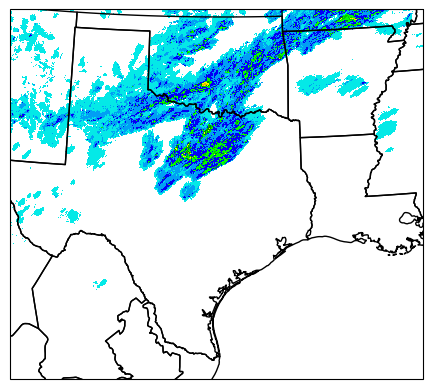

In [14]:
#plot the hail data
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(th_lon, th_lat, th_val, transform=cartopy.crs.PlateCarree(), cmap=cmap, vmin = 0, vmax=100)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.set_extent([-104.5,-90,25,37])

In [25]:
np.max(ds_th.HAIL_MAX2D.max(dim='Time').values) * 39.3701

2.35244098806642

In [16]:
np.max(ds_th.AFWA_HAIL.max(dim='Time').values)

23.078959

### NSSL 2-moment 4-ice scheme (steady background CCN)

In [17]:
#open the AFWA files together
ds = xr.open_mfdataset('/home/scratch/jcorner1/NWP_Project/data5/AFWA*', concat_dim="Time", combine="nested")

#merge the file with the geom file
ds = xr.merge([ds, new_geog.squeeze()], compat='override')
ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

#assign the lat/lons
ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
ds_nssldm = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
ds_nssldm

<xarray.Dataset>
Dimensions:         (Time: 37, south_north: 432, west_east: 515,
                     south_north_stag: 433, west_east_stag: 516, land_cat: 20,
                     soil_cat: 16, month: 12, dust_erosion_dimension: 3)
Coordinates:
    lat             (south_north, west_east) float32 ...
    lon             (south_north, west_east) float32 ...
    x               (west_east) int64 0 1 2 3 4 5 6 ... 509 510 511 512 513 514
    y               (south_north) int64 0 1 2 3 4 5 ... 426 427 428 429 430 431
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month,
                                dust_erosion_dimension
Data variables: (12/80)
    Times           (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    WSPD10MAX       (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_UP_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    W_DN_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    REFD_MAX        (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    UP_HELI_MAX     (Time, south_north, west_east) float32 dask.array<chunksize=(1, 432, 515), meta=np.ndarray>
    ...              ...
    OL4             (south_north, west_east) float32 ...
    VAR_SSO         (south_north, west_east) float32 ...
    LAKE_DEPTH      (south_north, west_east) float32 ...
    EROD            (dust_erosion_dimension, south_north, west_east) float32 ...
    CLAYFRAC        (south_north, west_east) float32 ...
    SANDFRAC        (south_north, west_east) float32 ...
Attributes: (12/85)
    TITLE:                            OUTPUT FROM WRF V4.3.3 MODEL
    START_DATE:                      2021-04-28_18:00:00
    WEST-EAST_GRID_DIMENSION:        516
    SOUTH-NORTH_GRID_DIMENSION:      433
    BOTTOM-TOP_GRID_DIMENSION:       50
    DX:                              3750.0
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

In [18]:
nssldm_lat = ds_nssldm.lat.values
nssldm_lon = ds_nssldm.lon.values
nssldm_val = ds_nssldm.HAIL_MAX2D.max(dim='Time').values * 1000

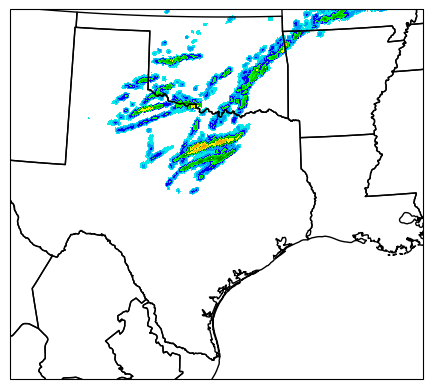

In [19]:
#plot the hail data
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
c = ax.pcolormesh(nssldm_lon, nssldm_lat, nssldm_val, transform=cartopy.crs.PlateCarree(), cmap=cmap, vmin = 0, vmax=100)
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.set_extent([-104.5,-90,25,37])

In [30]:
np.max(ds_nssldm.HAIL_MAXK1.max(dim='Time').values) * 39.3701

1.7545846650410444

## Full Comparison

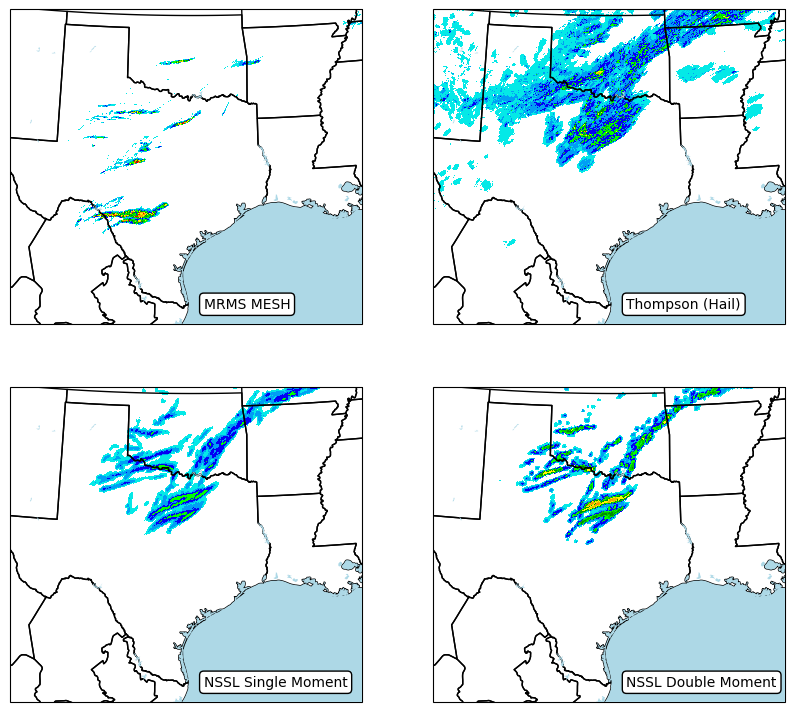

In [20]:
input_data = ['mesh', 'th', 'nsslsm', 'nssldm']
labels = ['MRMS MESH', 'Thompson (Hail)', 'NSSL Single Moment', 'NSSL Double Moment']

fig = plt.figure()
fig.set_size_inches(10, 9)

for i in range(len(input_data)):
    
    #plot the hail data
    ax = plt.subplot(2,2,i+1, projection=ccrs.LambertConformal(central_longitude=-97, central_latitude=31))
    c = ax.pcolormesh(locals()[f'{input_data[i]}_lon'], locals()[f'{input_data[i]}_lat'], locals()[f'{input_data[i]}_val'], transform=cartopy.crs.PlateCarree(), cmap=cmap, vmin = 0, vmax=100)
    
    ax.add_feature(cartopy.feature.STATES, zorder=2)
    ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
    ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue', zorder=3)
    ax.set_extent([-104.5,-90,25,37])
    
    ax.annotate(f'{labels[i]}', (0.55,0.05), xycoords='axes fraction',fontsize=10, 
                            bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)